![](https://i.ibb.co/bKGRGzB/Screenshot-from-2020-10-14-16-08-25.png)

>Real world data is messy and often contains a lot of missing values. There could be multiple  reasons for the missing values but primarily the reason for missingness can be attributed to 

| Reason for missing Data |  
|--|
|Data doesn't exist  |  
|Data not collected due to human error.  |  
|Data deleted accidently  |  
|                         |


<hr>


# A - Objective
The objective of this notebook is to detect missing values and then go over some of the methods used for imputing them.
<hr>


# 1 - Data

There are two publically available datasets which will be used to explain the concepts:

* 1. [Titanic Dataset](https://www.kaggle.com/c/titanic) for Non Time Series problem
* 2. [Air Quality Data in India (2015 - 2020)](https://www.kaggle.com/rohanrao/air-quality-data-in-india) for Time Series problem


# 2 - Loading necessary libraries and datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cd "....Session 2 - Data Preprocessing/Dataset/"

In [ ]:
cd "/content/drive/My Drive/03. Course FPT/Bigdata Analytics 2022/Tài liệu học viên HCM02 - 2022/Datasets"

/content/drive/My Drive/03. Course FPT/Bigdata Analytics 2022/Tài liệu học viên HCM02 - 2022/Datasets


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import seaborn as sns

## Reading in the dataset
* Reading in the Titanic Dataset.

In [ ]:
train = pd.read_csv('titanic_train.csv') 
print('Training data shape: ', train.shape) 
# First few rows of the training dataset
train.head()

Training data shape:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Examining the Target column 

>For each passenger in the test set, we need to create a model that predicts whether or not the passengers survived the sinking of the Titanic. Hence Survived is that target column in the dataset. Let's examine the Distribution of the target column

In [ ]:
# code here

In [ ]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

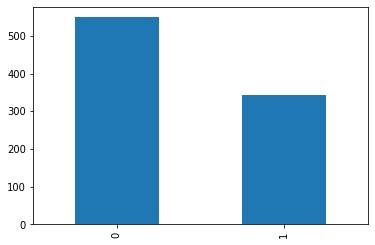

In [ ]:
train['Survived'].value_counts().plot(kind='bar')

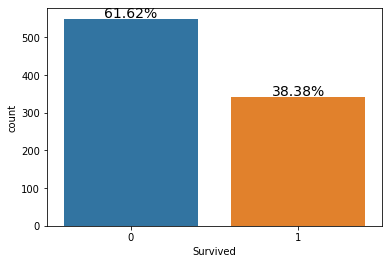

In [ ]:
s = sns.countplot(x = 'Survived',data = train)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}%'.format(height/len(train)*100), ha="center", fontsize=14) 

Here:
* 0: Did not Survive while 
* 1: Survived. 

Clearly, less people survived the accident.

# B - Detecting Missing values

## Detecting missing values numerically 

>The first step is to detect the count/percentage of missing values in every column of the dataset. This will give an idea about the distribution of missing values.

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
            columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# code here

In [ ]:
train_missing = missing_values_table(train)
train_missing

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [ ]:
train[train['Cabin'].isnull()].head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# C - Treating Missing values  

After having identified the patterns in missing values, it is important to treat them too. Here is a flowchart which could prove handy:



![](https://i.ibb.co/SRHYMmm/Screenshot-from-2020-10-14-16-26-32.png)

>Deletion means to delete the missing values from a dataset. This is however not recommended as it might result in loss of information from the dataset. We should only delete the missing values from a dataset if their proportion is very small. Deletions are further of three types: 

### Pairwise Deletion 

Parwise Deletion is used when values are missing completely at random i.e MCAR. During Pairwise deletion, only the missing values are deleted. All operations in pandas like mean,sum etc intrinsically skip missing values.




In [ ]:
# code here
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# train.mean().sort_values().reset_index().rename(columns={'index': 'column', 0: 'mean'})

In [ ]:
# train.describe().transpose()[['mean', 'min', 'max', '50%']].rename(columns={'50%': 'median'}).round(2)


### 1 - Listwise Deletion/ Dropping rows

>During Listwise deletion, complete rows(which contain the missing values) are deleted. As a result, it is also called Complete Case deletion. Like Pairwise deletion, listwise deletions are also only used for MCAR values.


In [ ]:
train[train['Age']>10].head()[['Name', 'Age']]

,Name,Age
0,"Braund, Mr. Owen Harris",22.0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0
2,"Heikkinen, Miss. Laina",26.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0
4,"Allen, Mr. William Henry",35.0


In [ ]:
dfx = train.isnull().sum().reset_index()
dfx[dfx[0] > 0]['index'].values

array(['Age', 'Cabin', 'Embarked'], dtype=object)

In [ ]:
train.columns[train.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [ ]:
train_missing.index

Index(['Cabin', 'Age', 'Embarked'], dtype='object')

In [ ]:
#Drop rows which contains any NaN or missing value for Age column
train_drop = train.dropna(subset=train_missing.index, how='any') #, inplace=True)

In [ ]:
missing_values_table(train)

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [ ]:
missing_values_table(train_drop)

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


>The Age column doesn't have any missing values.A major diadvantage of Listwise deletion is that a major chunk of data and hence a lot of information is lost. Hence, it is advisable to use it only when the number of missing values is very small.


### 2 - Dropping complete columns 

If a column contains a lot of missing values, say more than 80%, and the feature is not significant, you might want to delete that feature. However, again, it is not a good methodology to delete data.


## 3 - Imputations Techniques for non Time Series Problems 

![](https://i.ibb.co/f2NNH82/Screenshot-from-2020-10-14-16-26-51.png)

>Imputation refers to replacing missing data with substituted values.There are a lot of ways in which the missing values can be imputed depending upon the nature of the problem and data. Dependng upon the nature of the problem, imputation techniques can be broadly they can be classified as follows:


### Basic Imputation Techniques
  
  - Imputating with a constant value
  - Imputation using the statistics (mean, median or most frequent) of each column in which the missing values are located

For this we shall use the `The SimpleImputer` class from sklearn.

In [ ]:
missing_values_table(train)

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


**Question 1** - Đối với cột AGE, thay thế giá trị missing bằng các cách MEAN, MODE, MIN, MAX => TÍNH TỔNG cột AGE sau khi đã fillna các cách.

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

**Question 2** - Đối với **train**:
1. Chọn MODE của cabin
2. xác định hành khách có tuổi lớn nhất nhưng không có thông tin Cabin.
3. Fill miss cabin bằng giá trị (1) cho hành khách này



In [ ]:
X = train['Cabin'].mode().values[0]

In [ ]:
ID = train[
    (train['Age'] == train[train['Cabin'].isnull()]['Age'].max())]['PassengerId'].values[0]

In [ ]:
ID, X

(852, 'B96 B98')

In [ ]:
train[train['PassengerId'] == ID]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.775,NaN,S


In [ ]:
train.loc[train['PassengerId'] == ID, 'Cabin'] = X

In [ ]:
train[train['PassengerId'] == ID]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.775,B96 B98,S


**Question 3** - Hạng ghế **Pclass** nào có **tổng** giá trị của cả cột **Age** và **Cabin** missing là nhiều nhất?

In [ ]:
df1 = train[train['Age'].isnull()]['Pclass'].value_counts().reset_index()
df1

,index,Pclass
0,3,136
1,1,30
2,2,11


In [ ]:
df2 = train[train['Cabin'].isnull()]['Pclass'].value_counts().reset_index()
df2

,index,Pclass
0,3,478
1,2,168
2,1,40


In [ ]:
df3 = pd.merge(df1, df2, on='index')
df3.columns = ['Pclass', 'TotalAge', 'TotalCabin']
df3['Total'] = df3[['TotalAge', 'TotalCabin']].sum(axis=1)
df3.sort_values("Total", ascending=False)

,Pclass,TotalAge,TotalCabin,Total
0,3,136,478,614
2,2,11,168,179
1,1,30,40,70


In [ ]:
# imputing with a constant

from sklearn.impute import SimpleImputer

train_constant = train.copy()
#setting strategy to 'constant' 
mean_imputer = SimpleImputer(strategy='constant') # imputing using constant value
train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)
train_constant.isnull().sum()

In [ ]:
from sklearn.impute import SimpleImputer
train_most_frequent = train.copy()
#setting strategy to 'mean' to impute by the mean
mean_imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)

In [ ]:
train_most_frequent.isnull().sum()

## 4 - Imputations Techniques for Time Series Problems

Now let's look at ways to impute data in a typical time series problem. Tackling missing values in time Series problem is a bit different. The `fillna()` method is used for imputing missing values in such problems.

* Basic Imputation Techniques
  - 'ffill' or 'pad' - Replace NaN s with last observed value
  - 'bfill' or 'backfill' - Replace NaN s with next observed value
  -  Linear interpolation method

### Time Series dataset

The dataset is called [Air Quality Data in India (2015 - 2020)](https://www.kaggle.com/rohanrao/air-quality-data-in-india) Tand it contains air quality data and AQI (Air Quality Index) at hourly and daily level of various stations across multiple cities in India.The dataset has a lot of missing values and and is a classic Time series problem.

In [ ]:
city_day = pd.read_csv('city_day.csv')

In [ ]:
city_day.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
city_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


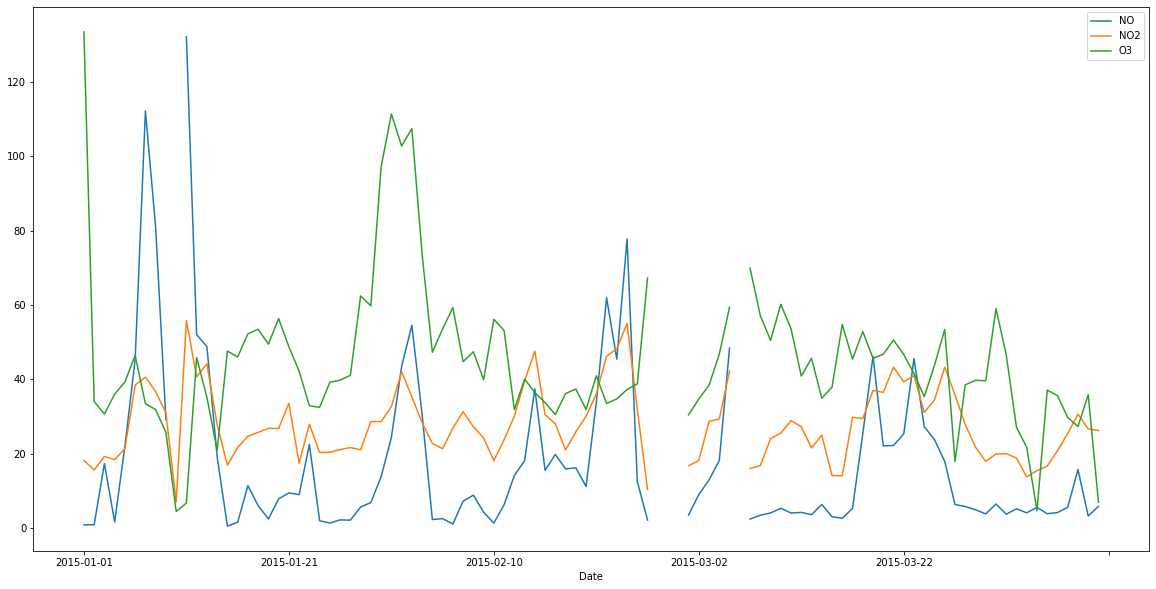

In [ ]:
city_day.head(100).set_index('Date')[['NO', 'NO2', 'O3']].plot(figsize=(20,10))

In [ ]:
city_day.shape

(29531, 16)

In [ ]:
#Missing Values
city_day_missing= missing_values_table(city_day)
city_day_missing

Your selected dataframe has 16 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Xylene,18109,61.3
PM10,11140,37.7
NH3,10328,35.0
Toluene,8041,27.2
Benzene,5623,19.0
AQI,4681,15.9
AQI_Bucket,4681,15.9
PM2.5,4598,15.6
NOx,4185,14.2
O3,4022,13.6


There are a lot of missing values and some of the columns like Xylene and PM10 have more than 50% of the values missing. Let's now see how we can impute these missing values.



In [ ]:
city_day.dtypes

City           object
Date           object
PM2.5         float64
PM10          float64
NO            float64
NO2           float64
NOx           float64
NH3           float64
CO            float64
SO2           float64
O3            float64
Benzene       float64
Toluene       float64
Xylene        float64
AQI           float64
AQI_Bucket     object
dtype: object

In [ ]:
# code here

In [ ]:
city_day['date'] = pd.to_datetime(city_day['Date'])

**Question 4**:

**Step 1:** Tạo data **df_sample** chỉ chứa cột **O3** từ dòng có index từ **10-20**

**Step 2:** Tạo cột **O3Missing** với các giá trị tương tự như cột **O3**, nhưng xoá đi các giá trị có index là **số chẵn**.

In kết quả dataframe sau khi đã xử lý xong.

In [ ]:
# code here

**Question 5**:

**Step 3:** Tạo các cột thoả mãn các điều kiện sau:

*   Cột **O3Mean**: fill missing bằng giá trị **MEAN**.
*   Cột **O3Median**: fill missing bằng giá trị **MEDIAN**.
*   Cột **O3Ffill**: fill missing bằng giá trị **LIỀN TRƯỚC**.

**Step 4:** Tính MAE của các cột sau khi đã fill: MAE_O3Mean, MAE_O3Mean, MAE_O3Mean. Chọn ra phương pháp fill missing có sai số nhỏ nhất.

In kết quả dataframe sau khi đã xử lý xong.


In [ ]:
# code here

**Question 6.** 

*   Xác định phương pháp fill missing tốt nhất (**MAX, MIN, MEAN, MEDIAN, BFILL, FFILL**) cho cột **Xylene** bằng việc: 

 > Đối với 50 records đầu tiên,  xoá và fill trên các vị trí các dòng có index chia hết cho 5 (giữ lại vị trí đầu tiên).
*   Sử dụng phương pháp tốt nhất đã tìm được, fill missing cho toàn bộ cột **Xylene**. Tính tổng cột **Xylene** mới.


In [ ]:
# code here

0

In [ ]:
# Imputation using ffill/pad
# Imputing Xylene value
# code here

In [ ]:
# Imputation using ffill/pad
# Imputing Xylene value

df_sample = city_day[['date', 'Xylene']][40:64]
df_sample['New'] = df_sample['Xylene'].fillna(method='ffill')
df_sample['DayOfWeek'] = df_sample['date'].dt.dayofweek

In [ ]:
df_mean = df_sample.groupby(['DayOfWeek'])['Xylene'].mean().reset_index()
df_mean.columns = ['DayOfWeek', 'Mean']

df_merge = pd.merge(df_sample, df_mean, on='DayOfWeek').sort_values('date').round(2)
df_merge.loc[~df_merge['Xylene'].isnull(), 'Mean'] = df_merge['Xylene']

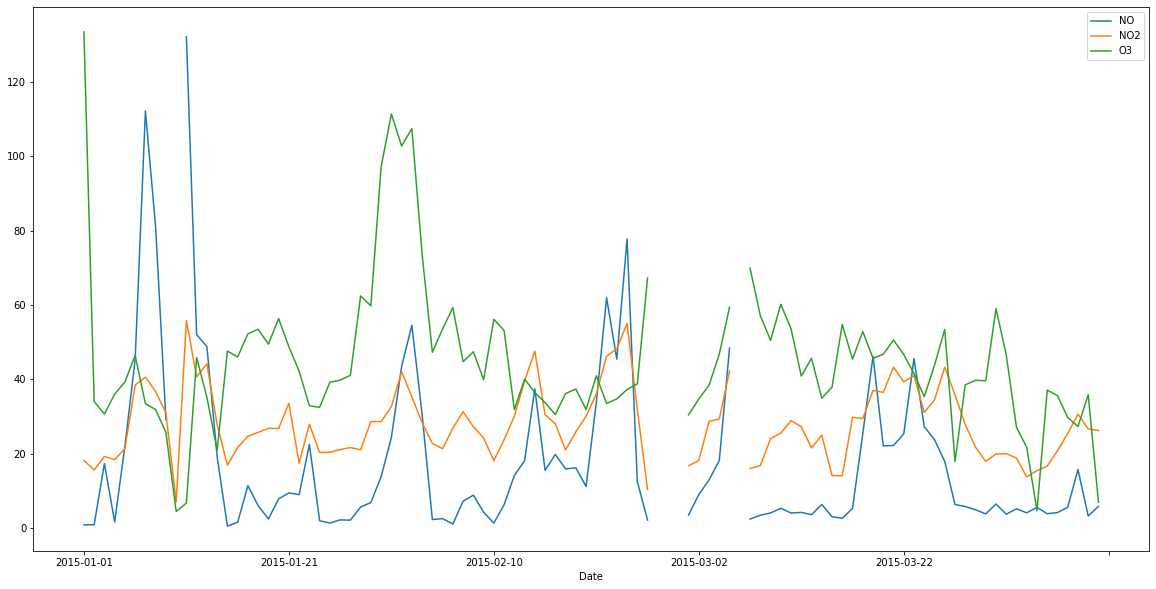

In [ ]:
city_day.head(100).set_index('Date')[['NO', 'NO2', 'O3']].plot(figsize=(20,10))

Above we see, there are 3 missing values in the Xylene column. 

### Imputing using ffill

In [ ]:
# code here

In [ ]:
city_day.fillna(method='ffill',inplace=True)
city_day['Xylene'][50:65]

50     7.48
51    15.44
52     8.47
53    28.46
54     6.05
55     0.81
56     0.81
57     0.81
58     0.81
59     1.32
60     0.22
61     2.25
62     1.55
63     4.13
64     4.13
Name: Xylene, dtype: float64

We can see that all missing values have been filled with the last observed values.

### Imputation using bfill

In [ ]:
# Imputing AQI value
# code here

In [ ]:
# Imputing AQI value

city_day['AQI'][20:30]

20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28    209.0
29    328.0
Name: AQI, dtype: float64

In [ ]:
city_day.fillna(method='bfill',inplace=True)
city_day['AQI'][20:30]

20    209.0
21    209.0
22    209.0
23    209.0
24    209.0
25    209.0
26    209.0
27    209.0
28    209.0
29    328.0
Name: AQI, dtype: float64

We can see that all missing values have been filled with the next observed values.

## 5 - Advanced Imputation Techniques 

Advanced imputation techniques uses machine learning algorithms to impute the missing values in a dataset unlike the previous techniques where we used other column values to predict the missing values. We shall look at the following two techniques in this notebook:

* [Nearest neighbors imputation](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)
* [Multivariate feature imputation](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)

### K-Nearest Neighbor Imputation

The [KNNImputer class](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation) provides imputation for filling in missing values using the k-Nearest Neighbors approach.Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. 

In [ ]:
train_knn = train.copy(deep=True)

In [ ]:
from sklearn.impute import KNNImputer
train_knn = train.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
train_knn['Age'] = knn_imputer.fit_transform(train_knn[['Age']])

In [ ]:
train_knn['Age'].isnull().sum()

0

### Multivariate feature imputation - Multivariate imputation by chained equations (MICE)
A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample ofthe data, then takes the average ofthe multiple regression values and uses that value to impute the missing value. In sklearn, it is implemented as follows:



In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
train_mice = train.copy(deep=True)

mice_imputer = IterativeImputer()
train_mice['Age'] = mice_imputer.fit_transform(train_mice[['Age']])

In [ ]:
train_mice['Age'].isnull().sum()

0